In [17]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import luit as lt    #Custom library for SUMMA (https://github.com/msaharia/luit) 
from jupyterthemes import jtplot

jtplot.style(theme='grade3')

In [14]:
#User-supplied
obsfile = '/glade/p/work/manab/fcast/data/dly/obsflow.dly.HHDW1.csv'
routefile = '/glade/p/work/manab/fcast/PNW_route/output/test1_out.nc'
polyshp = '/glade/p/work/manab/fcast/data/shapefile/Region_17_merged_hru.shp'
segshp =  '/glade/p/work/manab/fcast/data/shapefile/Region17_merged_seg.shp'

hid = 17007511  #HRU ID to be plotted
sid = 17003601  #Reach ID to be plotted
pltwidth = 15
pltheight = 5
starttime = '2010-10-01'
endtime = '2016-09-01'   

In [ ]:
summaoutfile = lt.concatHRUspatially('/glade/p/work/manab/fcast/HHDW1/output/hhdw1_test1', 'final.nc') 

In [18]:
summaout = xr.open_dataset(summaoutfile)
routeout = xr.open_dataset(routefile)

The 24 upstream HRU IDs are: [17007385 17007386 17007424 17007430 17007447 17007453 17007454 17007471
 17007483 17007498 17007511 17007517 17007536 17007541 17007550 17007554
 17007569 17007639 17009584 17009585 17009586 17009587 17009598 17009599]

The 12 REACH IDs are: [17003600 17003601 17003602 17003603 17003604 17003605 17003606 17003607
 17003608 17003616 17003617 17003618]



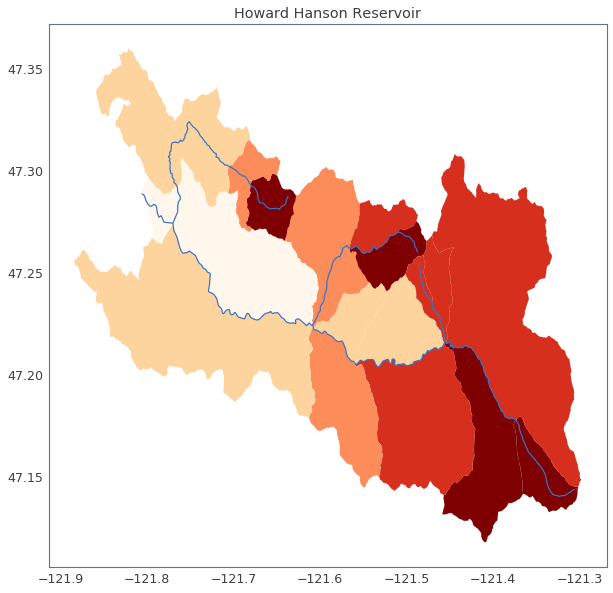

In [4]:
#Polygon shapefile
hrus = summaout['hruId'].values
print('The ' + str(len(hrus)) + ' upstream HRU IDs are: ' + str(hrus) + '\n')
polydat = lt.subShp(polyshp, 'hru_id2', hrus)

#Reach shapefile
reaches = routeout['reachID'].values
print('The ' + str(len(reaches)) + ' REACH IDs are: ' + str(reaches) + '\n')
segdat = lt.subShp(segshp, 'seg_id2', reaches)

#Plotting and overlaying
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title('Howard Hanson Reservoir')
polydat.plot(ax = ax, column = 'Elev_Avg', cmap='OrRd', scheme='quantiles')
segdat.plot(ax = ax)
ax.grid(False)

In [5]:
# Observed streamflow
o = pd.read_csv(obsfile)
o.rename(columns = {'Year':'time', 'cfs': 'flow'}, inplace=True)

o['flow'] = o['flow']*0.028316847 #Convert to CMS
o['time'] = pd.to_datetime(o['time'])  #convert to datetime format
o.loc[o['flow'] < 0 , 'flow'] = np.nan
o.fillna(method='ffill', limit=10)

o = o.set_index(['time'])
obs = o.to_xarray()

In [6]:
#Unit conversion
out = xr.open_dataset(summaoutfile).set_index(hru = 'hruId')

#Convert gru unit to hru unit
runoffdata = out['averageInstantRunoff'].values                     #Extract averageInstantRunoff values
runoffarray = xr.DataArray(runoffdata, dims=['time','hru'])            #Create an array of averageInstantRunoff with 2 dimensions
out = out.drop('averageInstantRunoff')                           #Drop the original averageInstantRunoff variable
out['averageInstantRunoff'] = runoffarray                           #Add the new array to original netCDF
out['averageInstantRunoff'].attrs['long_name'] = "instantaneous runoff (instant)"
out['averageInstantRunoff'].attrs['units'] = 'm s-1'
        
out

<xarray.Dataset>
Dimensions:                 (hru: 24, midToto: 8, time: 19248)
Coordinates:
  * hru                     (hru) int64 17007385 17007386 17007424 17007430 ...
  * time                    (time) datetime64[ns] 2010-06-01 ...
Dimensions without coordinates: midToto
Data variables:
    pptrate                 (time, hru) float64 ...
    airtemp                 (time, hru) float64 ...
    nSnow                   (time, hru) int32 ...
    nSoil                   (time, hru) int32 ...
    nLayers                 (time, hru) int32 ...
    numberFluxCalc          (time, hru) int32 ...
    scalarSWE               (time, hru) float64 ...
    mLayerTemp              (time, midToto, hru) float64 ...
    mLayerVolFracLiq        (time, midToto, hru) float64 ...
    scalarAquiferStorage    (time, hru) float64 ...
    scalarTotalSoilWat      (time, hru) float64 ...
    scalarRainPlusMelt      (time, hru) float64 ...
    scalarSurfaceRunoff     (time, hru) float64 ...
    scalarSoilBasefl

In [7]:
out['pptrate'] = out['pptrate']*3600      #kg m-2 s-1 -> mm/hr
out['averageInstantRunoff'] = out['averageInstantRunoff']*3600000  #m/s to mm/h
out['scalarAquiferBaseflow'] = out['scalarAquiferBaseflow']*3600000  #m/s to mm/h
out['scalarRainPlusMelt'] = out['scalarRainPlusMelt']*3600000  #m/s to mm/h
out['scalarAquiferRecharge'] = out['scalarAquiferRecharge']*3600000  #m/s to mm/h
out['scalarAquiferStorage'] = out['scalarAquiferStorage']*1000  #m to mm
out['scalarAquiferTranspire'] = out['scalarAquiferTranspire']*3600000  #m/s to mm/h
out['scalarSurfaceRunoff'] = out['scalarSurfaceRunoff']*3600000  #m/s to mm/h

# Summary Statistics (20101001 - 20160901)

In [11]:
param = {}
param['aquiferScaleFactor (Smax)'] = '3'
param['aquiferBaseflowRate(K)'] = '0.3'
param['aquiferBaseflowExp(c)'] = '1.5'

statsum = {}
statsum['pptrate (mm/h)'] = out['pptrate'].loc[starttime1:endtime1].sum().values
statsum['averageInstantRunoff (mm/h)'] = out['averageInstantRunoff'].loc[starttime1:endtime1].sum().values
statsum['scalarRainPlusMelt (mm/h)'] = out['scalarRainPlusMelt'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferRecharge (mm/h)'] = out['scalarAquiferRecharge'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferBaseflow (mm/h)'] = out['scalarAquiferBaseflow'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferStorage (mm)'] = out['scalarAquiferStorage'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferTranspire (mm/h)'] = out['scalarAquiferTranspire'].loc[starttime1:endtime1].sum().values

statavg = {}
statavg['pptrate (mm/h)'] = out['pptrate'].loc[starttime1:endtime1].mean().values
statavg['averageInstantRunoff (mm/h)'] = out['averageInstantRunoff'].loc[starttime1:endtime1].mean().values
statavg['scalarRainPlusMelt (mm/h)'] = out['scalarRainPlusMelt'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferRecharge (mm/h)'] = out['scalarAquiferRecharge'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferBaseflow (mm/h)'] = out['scalarAquiferBaseflow'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferStorage (mm)'] = out['scalarAquiferStorage'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferTranspire (mm/h)'] = out['scalarAquiferTranspire'].loc[starttime1:endtime1].mean().values

#totalbaseflow = statsum['scalarAquiferBaseflow (mm/h)'] 
#totalstreamflow = out.sel(hru = hid)['scalarAquiferRecharge'].loc[starttime1:endtime1].sum().values

#bfi = totalbaseflow / totalstreamflow
#print(bfi)

print('\n BASEFLOW PARAMETERS')
for x in param:
    print (x,':',param[x])
    
    
print('\n SUM')
for x in statsum:
    print (x,':',statsum[x])
    
print('\n AVERAGE')
for x in statavg:
    print (x,':',statavg[x])
    
print ('Runoff Ratio (total)',':', list(statsum.values())[1]/list(statsum.values())[0]) 


 BASEFLOW PARAMETERS
aquiferScaleFactor (Smax) : 3
aquiferBaseflowRate(K) : 0.3
aquiferBaseflowExp(c) : 1.5

 SUM
pptrate (mm/h) : 97774.74092700548
averageInstantRunoff (mm/h) : 144831.17534101778
scalarRainPlusMelt (mm/h) : 62247.60224411419
scalarAquiferRecharge (mm/h) : 72415.58840669524
scalarAquiferBaseflow (mm/h) : 72415.5869343208
scalarAquiferStorage (mm) : 29809.826765232738
scalarAquiferTranspire (mm/h) : 0.0

 AVERAGE
pptrate (mm/h) : 0.23543386145545703
averageInstantRunoff (mm/h) : 0.3487420426419175
scalarRainPlusMelt (mm/h) : 0.149887314696299
scalarAquiferRecharge (mm/h) : 0.17437102309363742
scalarAquiferBaseflow (mm/h) : 0.17437101954827594
scalarAquiferStorage (mm) : 0.07177971077311782
scalarAquiferTranspire (mm/h) : 0.0
Runoff Ratio (total) : 1.48127393607


# PLOTS

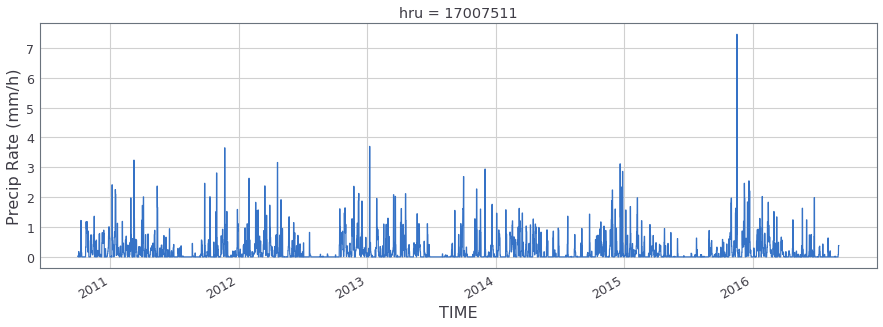

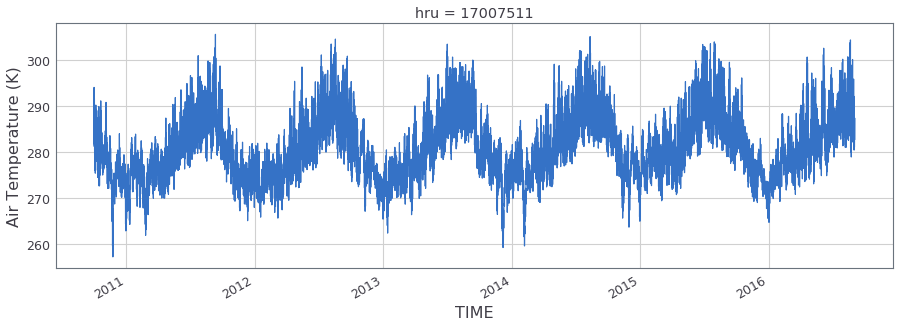

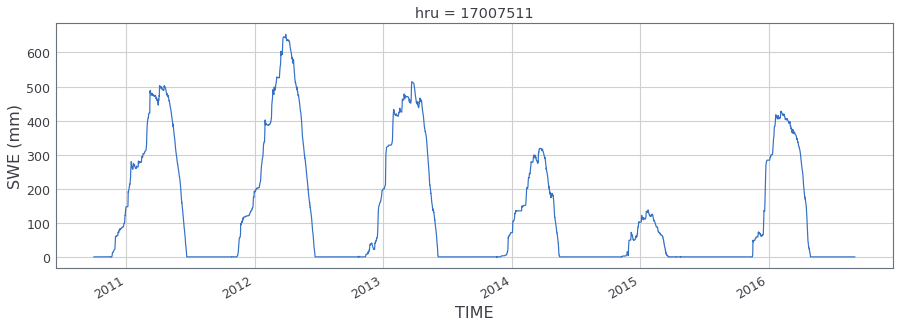

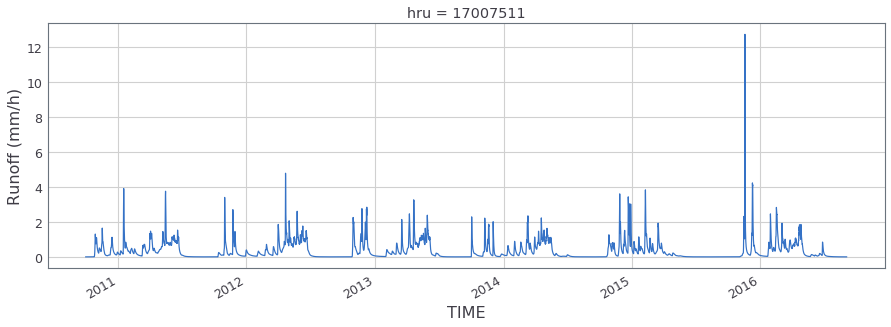

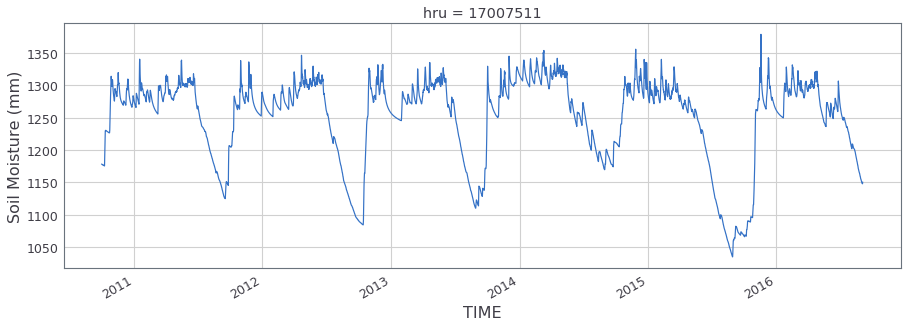

In [12]:
outsel = out.sel(hru = hid)

lt.plotncvar(outsel, 'pptrate', starttime, endtime, 'Precip Rate (mm/h)', 'TIME')
lt.plotncvar(outsel, 'airtemp', starttime, endtime, 'Air Temperature (K)', 'TIME')
lt.plotncvar(outsel, 'scalarSWE', starttime, endtime, 'SWE (mm)', 'TIME')
lt.plotncvar(outsel, 'averageInstantRunoff', starttime, endtime, 'Runoff (mm/h)', 'TIME')
lt.plotncvar(outsel, 'scalarTotalSoilWat', starttime, endtime, 'Soil Moisture (mm)', 'TIME')

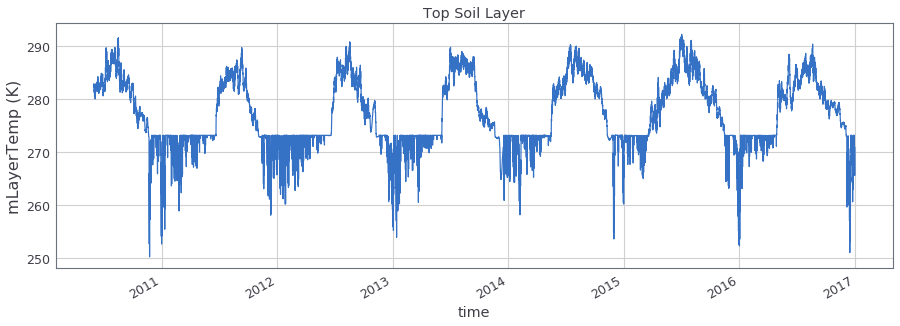

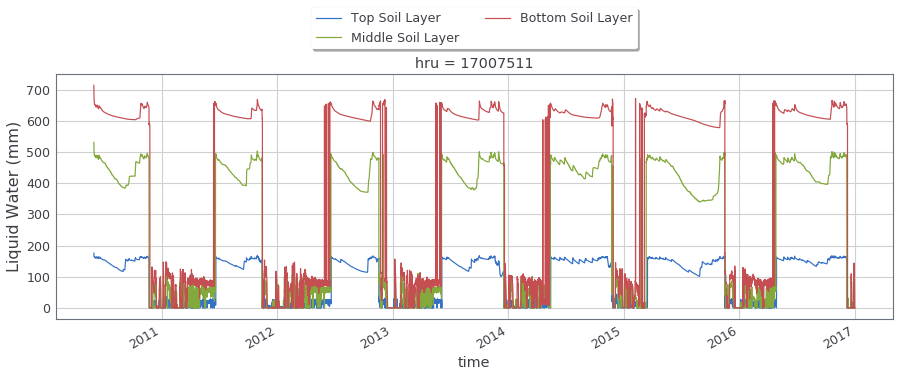

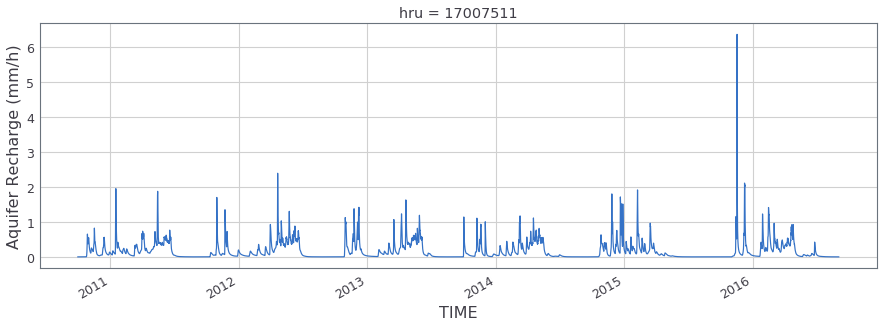

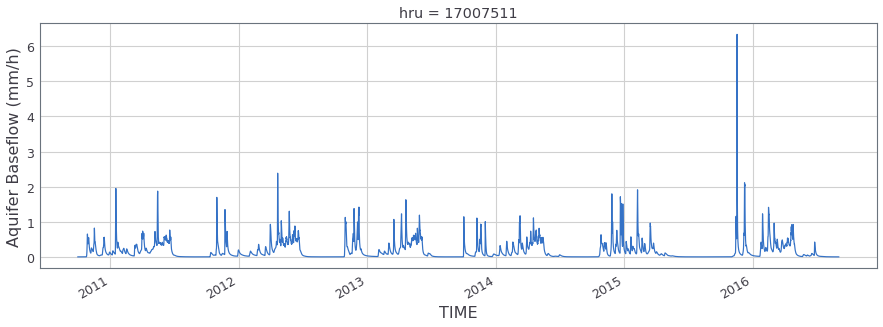

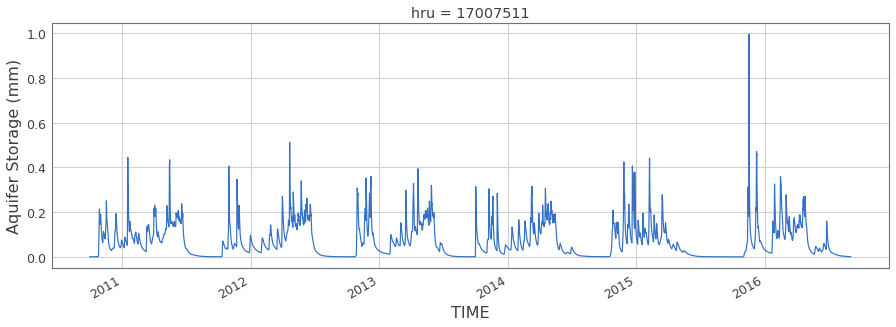

In [13]:
#mLayerTemp
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru=hid)['mLayerTemp'][:, 0].plot(label = 'Top')
plt.ylabel('mLayerTemp (K)', fontsize = 16)
plt.title('Top Soil Layer')
plt.show()

#mLayerVolFracLiq
iden_water = 1000
plt.figure(figsize=(pltwidth, pltheight))
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 0]*iden_water*0.5).plot(label='Top Soil Layer')
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 1]*iden_water*1.5).plot(label='Middle Soil Layer')
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 2]*iden_water*2.0).plot(label='Bottom Soil Layer')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=True)
plt.ylabel('Liquid Water (mm)', fontsize=16) 
plt.show()

lt.plotncvar(outsel, 'scalarAquiferRecharge', starttime, endtime, 'Aquifer Recharge (mm/h)', 'TIME')
lt.plotncvar(outsel, 'scalarAquiferBaseflow', starttime, endtime, 'Aquifer Baseflow (mm/h)', 'TIME')
lt.plotncvar(outsel, 'scalarAquiferStorage', starttime, endtime, 'Aquifer Storage (mm)', 'TIME')

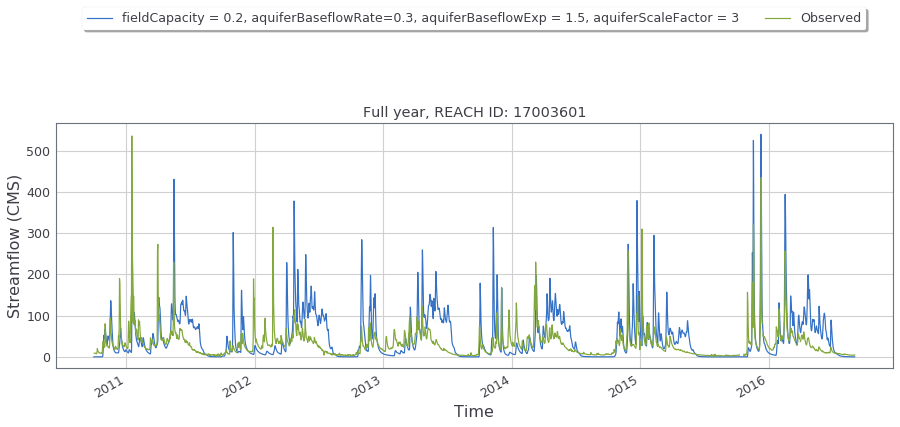

In [16]:
#Streamflow
routeout = xr.open_dataset(routefile).set_index(sSeg = 'reachID')

#PLOT 1
plt.figure(figsize=(pltwidth,pltheight))
routeout.sel(sSeg = sid)['IRFroutedRunoff'].loc[starttime1:endtime1].plot(label='fieldCapacity = 0.2, aquiferBaseflowRate=0.3, aquiferBaseflowExp = 1.5, aquiferScaleFactor = 3')
(obs['flow'].loc[starttime1:endtime1]).plot(label='Observed')
plt.ylabel('Streamflow (CMS)', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Full year, REACH ID: %i' %sid)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=True)
plt.show()

In [ ]:
# Streamflow statistics